In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add project 1 to sys path 
import sys
sys.path.append('../project1/')
import tools as proj1_tools
import project2_tools as proj2_tools

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
L = 40
temps = proj2_tools.get_available_t()
states = proj2_tools.read_t(temps[0])
#states.shape

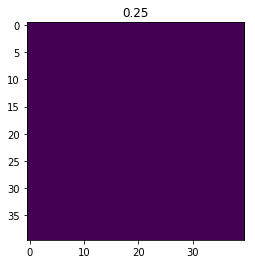

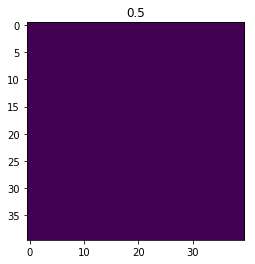

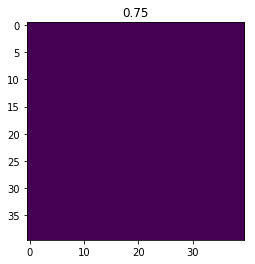

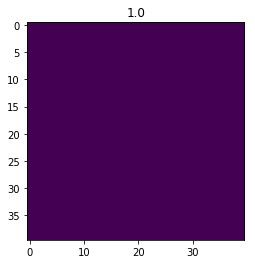

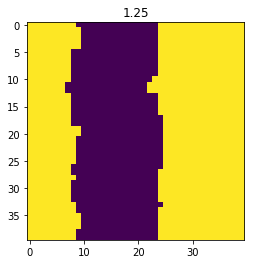

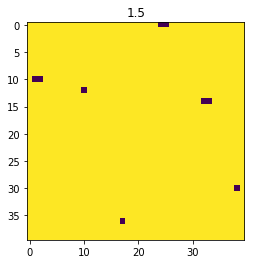

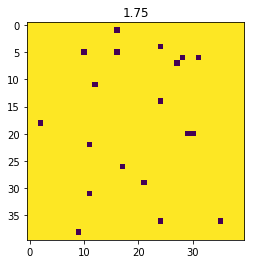

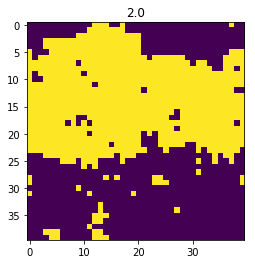

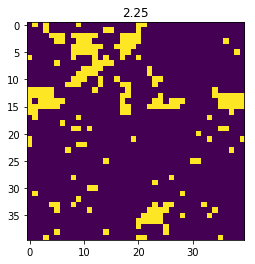

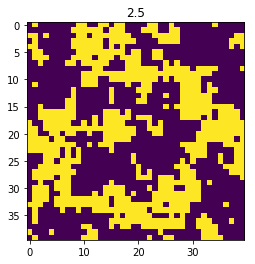

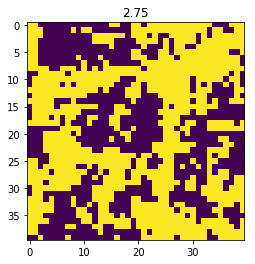

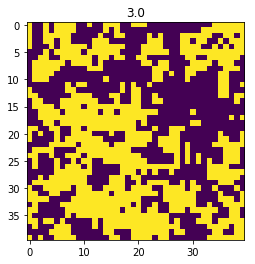

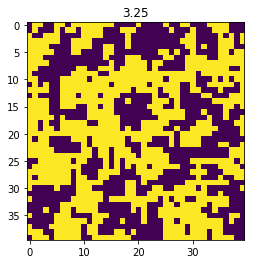

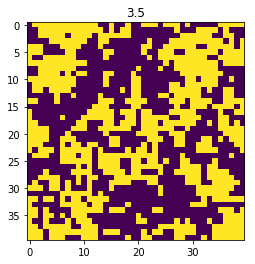

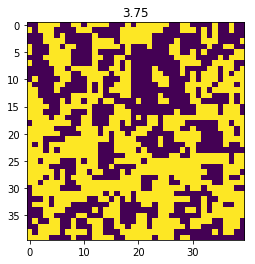

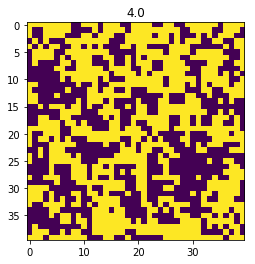

In [78]:
#print(temps)
t_crit = 2.3
for t_low in temps:
    
    label = int(t_crit > t_low)
    
    plt.figure()
    states_low_t = proj2_tools.read_t(t_low)
    plt.imshow(states_low_t[1].reshape(L,L))
    plt.title(t_low)

# Two dimensional Ising Model 

Make training data

In [79]:
def get_train_data(n, L):
    """Pick some random training data from whole data set"""
    Nt = temps.size
    Nl = L * L
    data = np.zeros((Nt, n, Nl),dtype=np.int8)
    for i,t in enumerate(temps):
        d = proj2_tools.read_t(t)
        d[np.where(d == 0)] = -1
        data[i] = d
        
    n_ordered = np.sum(temps > t_crit)
    classes = np.zeros((Nt,n),dtype = np.int8)
    classes[:-n_ordered] = 1
    
    data = data.reshape(-1, Nl)
    
    classes = classes.ravel()
    return data, classes

    
n = 10000
L = 40
data,classes = get_train_data(n, L)

In [80]:
N_train = 1000

np.random.seed(0)
indx = np.arange(data.shape[0])
np.random.shuffle(indx)

X_train = data[indx][:N_train]
X_train = np.c_[np.ones_like(X_train[:,0]), X_train]
y_train = classes[indx][:N_train]

X_test = data[indx][N_train:2*N_train]
X_test = np.c_[np.ones_like(X_test[:,0]), X_test]
y_test = classes[indx][N_train:2*N_train]

X_test2 = data[indx][2*N_train:3*N_train]
X_test2 = np.c_[np.ones_like(X_test2[:,0]), X_test2]
y_test2 = classes[indx][2*N_train:3*N_train]

X_test3 = data[indx][3*N_train:4*N_train]
X_test3 = np.c_[np.ones_like(X_test3[:,0]), X_test3]
y_test3 = classes[indx][3*N_train:4*N_train]


#Nd = 2
#Np = X.shape[1]

# Logistic regression
##### Compared with $sklearn.linear\_model.LogisticRegression$

In [11]:
import logreg
from sklearn.linear_model import LogisticRegression

Prepare test sets and variables:

In [96]:
X_testset = np.concatenate((X_test,X_test2,X_test3),axis=0)
y_testset = np.concatenate((y_test,y_test2,y_test3),axis=0)
Xtestset = [X_test,X_test2,X_test3]
ytestset = [y_test,y_test2,y_test3]

lmbd=1
iterations = 1000

#### Train/Test of our model

In [88]:
#lrs = [1e-07,1e-06,1e-05,1e-04,1e-03,1e-02]#,1e-01,1e-00,1e01]
lms = [1e-06,1e-05]#,1e-00,1e01,1e02,1e03]#,1e-01,1e-00,1e01]
error=[]
ypreds = []
for i,lm in enumerate(lms):
    regr = logreg.Logistic_Regression(learn_rate=1e-03, iterations=1000, lmbd=lm,tol=1e-05)
    err = regr.fit(X_train,y_train)
    error.append(err)
    ypred = regr.predict(X_testset)
    ypreds.append(ypred)
    print('lambda={:<7} -> acc={}'.format(lm,regr.accuracy(y_testset,ypred)))


lambda=1e-06   -> acc=0.5026666666666667
lambda=1e-05   -> acc=0.507


Text(0.5,1,'Error')

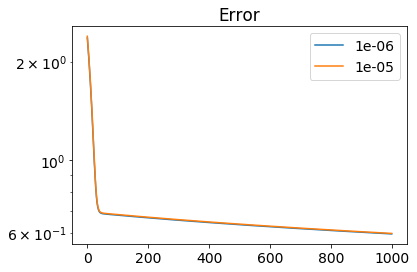

In [62]:
skip=0
for i,err in enumerate(error):
        plt.semilogy(np.linspace(skip,len(err)-skip,len(err)-skip),err[skip:],label=str(lms[i]))

plt.legend()
plt.title('Error')

In [85]:
regr = logreg.Logistic_Regression(learn_rate=1e-02, iterations=1000, lmbd=1e-04,tol=1e-05)
err = regr.fit(X_train,y_train)
print(regr.accuracy(y_testset,regr2.predict(X_testset)))
print(regr.beta)

0.6853333333333333
[ 0.47736358  0.02406778  0.01426913 ...  0.00260011 -0.01519479
 -0.0026862 ]


Statistics:

In [98]:
# Train
z_train = regr.predict(X_train)
acc_train1 = regr.accuracy(y_train,z_train)
mse_train1 = np.sum(np.abs(z_train-y_train)**2)/y_train.shape[0]
# Test
acc_test1 = []
mse_test1 = []
for i,test in enumerate(Xtestset):
    z_test = regr.predict(test)
    acc_test1.append(regr.accuracy(ytestset[i],z_test))
    mse_test1.append(np.sum(np.abs(ytestset[i]-z_test)**2)/ytestset[i].shape[0])

#### Train/Test of sklearn model:

In [67]:
Lregr = LogisticRegression(random_state=1,verbose=0,max_iter=iterations,tol=1E-5, solver='lbfgs', fit_intercept=False)
Lregr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=1e-05, verbose=0, warm_start=False)

Statistics:

In [68]:
# Train
L_z_train = Lregr.predict(X_train)
acc_train2 = regr.accuracy(y_train,L_z_train)
mse_train2 = np.sum(np.abs(L_z_train-y_train)**2)/y_train.shape[0]

# Test
acc_test2 = []
mse_test2 = []
for i,test in enumerate(Xtestset):
    L_z_test = Lregr.predict(test)
    acc_test2.append(Lregr.score(test,ytestset[i]))
    mse_test2.append(np.sum(np.abs(ytestset[i]-L_z_test)**2)/ytestset[i].shape[0])

#### Compare

In [87]:
print('   {:<10}{:<15}{:<15}'.format('','Our model', 'sklearn model'))
print('\nTrain set :\n')
print('   {:<10}{:<15}{:<15}'.format('Accuracy',acc_train1,acc_train2))
print('   {:>8}  {:<15}{:<15}'.format('MSE',mse_train1,mse_train2))
for i in range(len(acc_test1)):
    print('\nTest set {}:\n'.format(i+1))
    #print('{:<10}{:<15}{:<15}'.format('','Our model', 'sklearn model'))
    print('   {:<10}{:<15}{:<15}'.format('Accuracy',acc_test1[i],acc_test2[i]))
    print('   {:>8}  {:<15}{:<15}'.format('MSE',mse_test1[i],mse_test2[i]))

             Our model      sklearn model  

Train set :

   Accuracy  0.989          1.0            
        MSE  0.011          0.0            

Test set 1:

   Accuracy  0.678          0.669          
        MSE  0.322          0.331          

Test set 2:

   Accuracy  0.684          0.673          
        MSE  0.316          0.327          

Test set 3:

   Accuracy  0.689          0.67           
        MSE  0.311          0.33           


#### Best learn rate and regularization

In [3]:
from IPython.display import clear_output
import time

In [9]:
lmbds = np.concatenate((np.zeros(1),np.logspace(-8,3,12)),axis=0)
lr = np.logspace(-8,0,9)

accuracy_scores=np.zeros((lmbds.shape[0],lr.shape[0]))
accuracy_scores.shape

In [13]:
fullnum=lmbds.shape[0]*lr.shape[0]
num=1
t1 = time.time()
best_var=1e09
var_num = 0
for i,lmbd in enumerate(lmbds):
    #print('Lambda = ',lmbd,':')
    for j,l_r in enumerate(lr):
        t2 = time.time()
        print('{}/{} - {}s left'.format(num,fullnum, (t2-t1)*(fullnum-num)))
        #print('Learning rate = ',l_r,':')
        regr = logreg.Logistic_Regression(learn_rate=l_r, iterations=1000, lmbd=lmbd,tol=1e-05)
        regr.fit(X_train,y_train)
        z_train = regr.predict(X_train)
        #print('Train Accuracy: ',regr.accuracy(y_train,z_train))
        #print('Train Squared error: ', np.sum(np.abs(z_train-y_train)**2)/y_train.shape[0])
        z_test = regr.predict(X_testset)
        acc = regr.accuracy(y_testset,z_test)
        accuracy_scores[i,j]=acc
        #print('Test Accuracy: ',acc)
        #print('Test Squared error: ', np.sum(np.abs(z_test-y_testset)**2)/y_testset.shape[0])
        #df.loc[lmbd,lr] = acc
        #print('--------------')
        if np.var(regr.beta) < best_var:
            var_num = [i,j]
        num+=1
        t1 = t2
        clear_output(wait=0.1)
    #print('----------------------------')


117/117 - 0.0s left


/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project2/logreg.py:63: RuntimeWarning: overflow encountered in double_scalars
  return -y.T @ np.log(p) - (1 - y.T) @ np.log(1 - p) + np.sum(self.lmbd*np.sum(self.beta**2))
/Users/heine2307/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project2/logreg.py:63: RuntimeWarning: overflow encountered in square
  return -y.T @ np.log(p) - (1 - y.T) @ np.log(1 - p) + np.sum(self.lmbd*np.sum(self.beta**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project2/logreg.py:33: RuntimeWarning: overflow encountered in multiply
  grad = (X.T @ (p - y) - 2*self.lmbd*self.beta)/n
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project2/logreg.py:43: RuntimeWarning: invalid value encountered in greater_equal
  return 1*(self.ypred >= 0.5) #Get binary valu

In [29]:
Lregr = LogisticRegression(fit_intercept=False, max_iter=1000, solver='lbfgs', penalty='l2',multi_class='multinomial')
Lregr.fit(X_train,y_train)
Lz_test = Lregr.predict(X_testset)
np.sum(np.equal(y_testset,Lz_test)) / y_testset.shape[0]

0.671

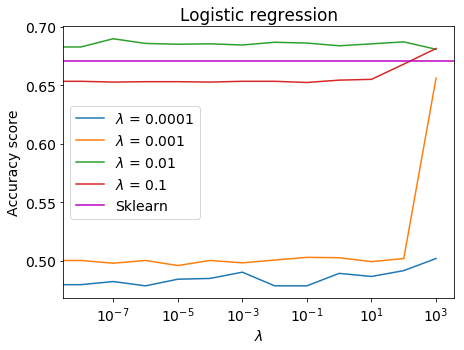

In [48]:
accuracy_scores.shape
#print(lr)
plt.tight_layout
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = [7,5])
for i,l_r in enumerate(lr):
    if i == 0 or i ==1 or i == 2 or i == 3 or i == 8 or i == 9:
        continue
    plt.semilogx(lmbds,accuracy_scores[:,i],label=r'$\lambda$ = '+str(l_r))
plt.axhline(0.671,label='Sklearn',color='m')
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel('Accuracy score')
plt.title('Logistic regression')
plt.savefig('acc_logreg.pdf')